Script to allow computing and visualisation of your data.

In [34]:
#Importe les packages nécessaires

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import linregress
import matplotlib.dates as mdates

sns.set(style="whitegrid")

In [35]:
#Importe les données dans le Notebook
data = pd.read_csv(r"C:\Users\masl0012\OneDrive - UQAR\Cours UQAR\Stage 2\TP3\dummydata.csv")

#Identifie la colonne date
data["datetime"] = pd.to_datetime(data["datetime"])

#Utiliser les dates comme index
data.set_index("datetime", inplace=True)

#Show the first row of your data
data.head()

,te_air_-140_65,te_roc_1_67,te_roc_13_56,te_roc_43_57,te_roc_73_58,te_roc_103_59,te_roc_133_60
datetime,,,,,,,
2023-01-01 00:00:00,-8.898,-9.066,-7.87,-7.75,-7.56,-7.31,-7.12
2023-01-01 01:00:00,-9.508,-9.134,-7.81,-7.75,-7.56,-7.31,-7.12
2023-01-01 02:00:00,-9.782,-9.202,-7.87,-7.75,-7.56,-7.31,-7.12
2023-01-01 03:00:00,-9.747,-9.269,-7.93,-7.75,-7.56,-7.31,-7.12
2023-01-01 04:00:00,-9.885,-9.303,-7.93,-7.75,-7.56,-7.25,-7.12


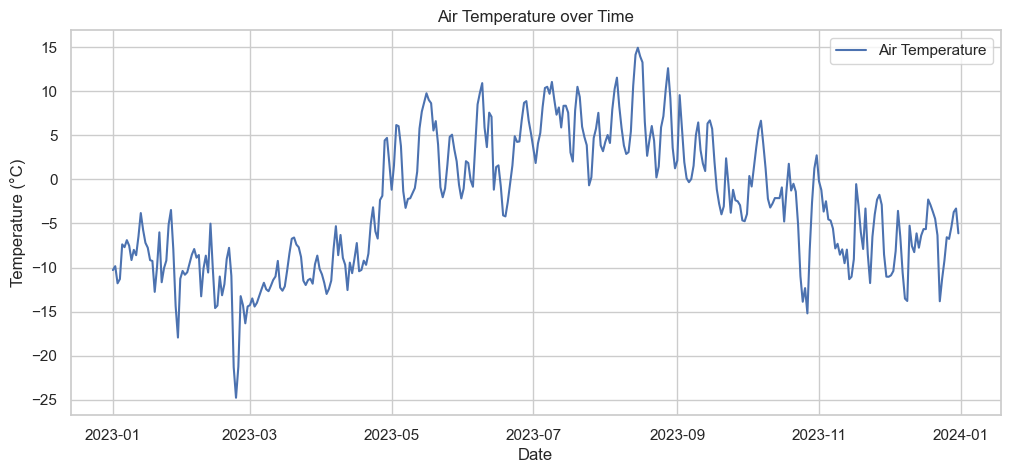

In [69]:
#produire graphique des température de l'air

#Sélectionner seulement les températures de l'air
Ta = data["te_air_-140_65"]

#Ta = Ta.resample("1D").mean()

#Indiquer les attributs de la figure
plt.figure(figsize=(12, 5))
plt.plot(Ta.index, Ta.values, label="Air Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Air Temperature over Time")
plt.legend()
plt.show()

In [60]:
#Produire une matrice de température avec les données de température du sol

#Sélectionner toutes les colonnes sauf celle de l'air
Tsol = data.drop(columns=["te_air_-140_65"])

#Renommer les colonnes selon la profondeur
Tsol.columns = [col.split('_')[2] for col in Tsol.columns]

#Print le début du DataFrame
print(Tsol.head())

                         1    13    43    73   103   133
datetime                                                
2023-01-01 00:00:00 -9.066 -7.87 -7.75 -7.56 -7.31 -7.12
2023-01-01 01:00:00 -9.134 -7.81 -7.75 -7.56 -7.31 -7.12
2023-01-01 02:00:00 -9.202 -7.87 -7.75 -7.56 -7.31 -7.12
2023-01-01 03:00:00 -9.269 -7.93 -7.75 -7.56 -7.31 -7.12
2023-01-01 04:00:00 -9.303 -7.93 -7.75 -7.56 -7.25 -7.12


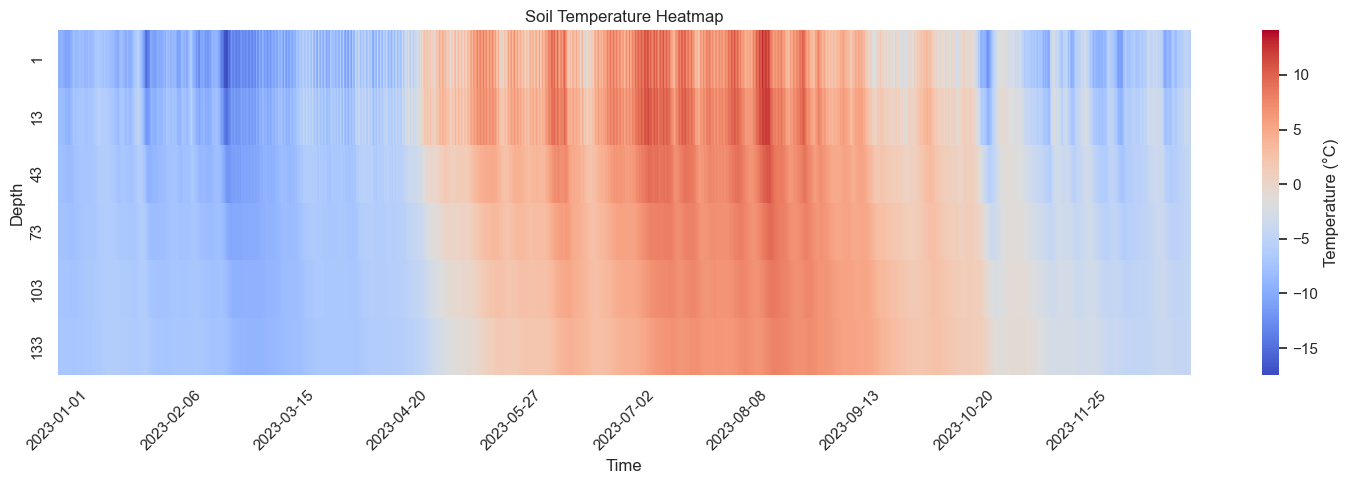

In [57]:
#Produire une matrice spatiotemporelle

# Transpose so depths are rows, time is columns
Tsol_T = Tsol.T

plt.figure(figsize=(15, 5))
ax = sns.heatmap(Tsol_T, cmap="coolwarm", cbar_kws={'label': 'Temperature (°C)'}, xticklabels=False)

# Set the x-ticks manually using the datetime index
ax.set_xticks(range(0, len(Tsol.index), max(1, len(Tsol.index)//10)))  # 10 ticks max
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in Tsol.index[::max(1, len(Tsol.index)//10)]], rotation=45)

plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Soil Temperature Heatmap")
plt.tight_layout()
plt.show()

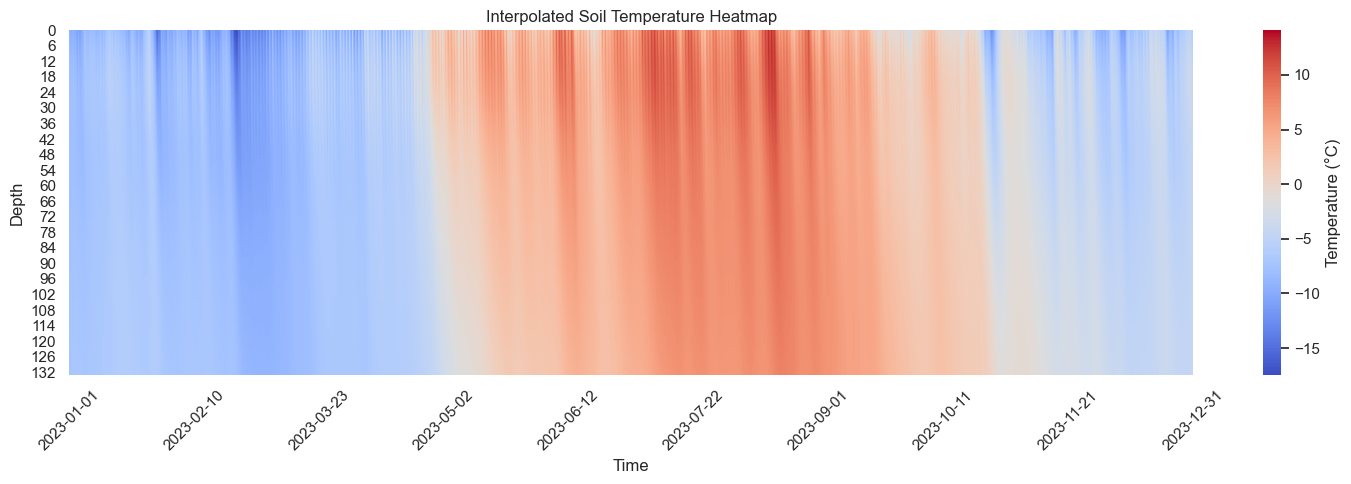

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Assume Tsol: DataFrame with index = datetime, columns = depths
# Transpose so depth = 1st axis, time = 2nd axis
depths = Tsol.columns.astype(int)
times = mdates.date2num(Tsol.index.to_pydatetime())  # convert to numerical dates for interpolation

# Create a finer depth grid
depth_fine = np.linspace(depths.min(), depths.max(), 133)

# Interpolate for each timestamp
Tsol_fine = []
for t in range(len(Tsol)):
    f = interp1d(depths, Tsol.iloc[t, :], kind='cubic')
    Tsol_fine.append(f(depth_fine))
Tsol_fine = np.array(Tsol_fine).T  # now shape = depth_fine x time

# Plot
plt.figure(figsize=(15, 5))
ax = sns.heatmap(Tsol_fine, cmap="coolwarm", cbar_kws={'label': 'Temperature (°C)'}, xticklabels=False)

# Set x-ticks using original dates
tick_idx = np.linspace(0, len(Tsol.index)-1, 10, dtype=int)
ax.set_xticks(tick_idx)
ax.set_xticklabels([Tsol.index[i].strftime('%Y-%m-%d') for i in tick_idx], rotation=45)

plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Interpolated Soil Temperature Heatmap")
plt.tight_layout()
plt.show()


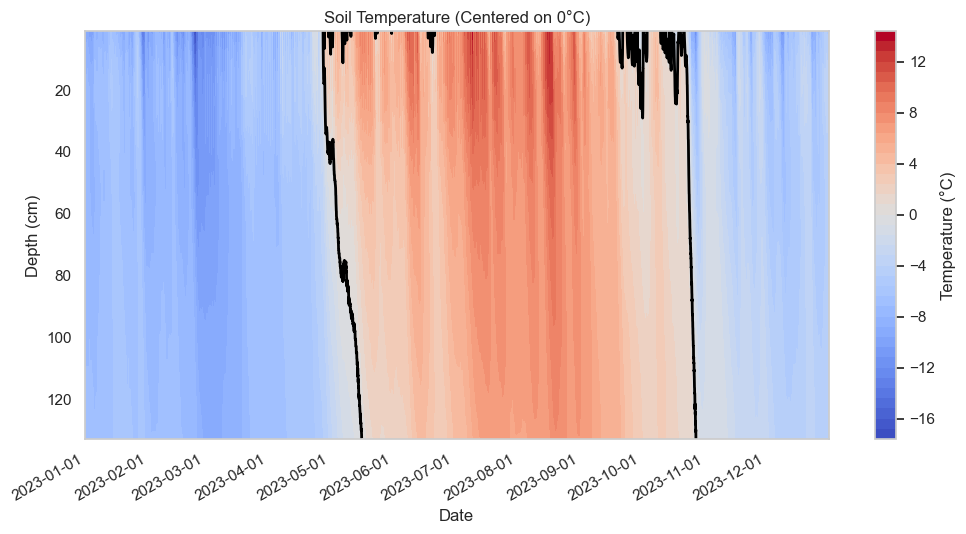

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm

# Convert column names to numeric depths
depths = Tsol.columns.astype(int)
times = mdates.date2num(Tsol.index.to_pydatetime())  # convert datetime to float for plotting

# Interpolate along depths to have a smoother grid
depth_grid = np.linspace(depths.min(), depths.max(), 100)  # fine depth grid
temp_smooth = np.empty((len(times), len(depth_grid)))

for i, t in enumerate(Tsol.index):
    f = interp1d(depths, Tsol.loc[t], kind='cubic')
    temp_smooth[i, :] = f(depth_grid)

# Transpose: now X=time, Y=depth
X, Y = np.meshgrid(times, depth_grid)
Z = temp_smooth.T  # transpose to match X=time, Y=depth

# Normalize colormap around 0
vmin = np.min(Z)
vmax = np.max(Z)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot heatmap
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, Z, cmap='coolwarm', levels=50, norm=norm)
plt.colorbar(label='Temperature (°C)')

# Overlay 0°C line
plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=2)

# Format x-axis as dates
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Depth (cm)')
plt.title('Soil Temperature (Centered on 0°C)')
plt.gcf().autofmt_xdate()
plt.gca().invert_yaxis()  # depth increases downward
plt.show()

